In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
import sys
sys.path.append("HateRecognition/target_model/")
from utils import preprocessing, load_anno_data, data_loader, define_target, create_model
from bertopic import BERTopic
from TopicTuner.topictuner import TopicModelTuner as TMT
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.model_selection import StratifiedKFold
from hdbscan import HDBSCAN
from sklearn.metrics import confusion_matrix
sys.path.append("../")
from TweetNormalizer import normalizeTweet
import gc
from cleantext import clean
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with_topic=True
file_name = "large_toxigen"
model_name = "hatexplain_bt_melted"

In [3]:
df = pd.read_csv(fr'../data/ready_data/{file_name}.csv')
df

,Unnamed: 0.1,Unnamed: 0,prompt,text,generation_method,target,prompt_label,roberta_prediction,lang
0,0,0,- the vast majority of african-americans are p...,"if youre white , you should be proud to be whi...",ALICE,African,1,0.001,en
1,1,1,- black people from the middle ages have alway...,the best thing that could have happened to the...,ALICE,African,1,0.044,en
2,2,2,- many african americans are so savage they lo...,theres no hope for the future because theres n...,ALICE,African,1,0.014,en
3,3,3,- the vast majority of african-americans are p...,"if youre white , you should be proud of it .",ALICE,African,1,0.002,en
4,4,4,"- whether a scientist or janitor, black people...","no matter how much money or power you have , i...",ALICE,African,1,0.328,en
...,...,...,...,...,...,...,...,...,...
238483,238483,250946,- although traditionally women were not allowe...,my chinese name is ai-lun ( hui ke ) . - my fa...,top-k,other,0,0.006,en
238484,238484,250947,- although traditionally women were not allowe...,i can't believe they won,top-k,other,0,0.720,en
238485,238485,250948,- although traditionally women were not allowe...,fin had a reputation as a musicians ' city,top-k,other,0,0.001,en
238486,238486,250949,- although traditionally women were not allowe...,i am thinking about getting a pet dog,top-k,other,0,0.006,en


In [4]:
if with_topic:
    topic_model = BERTopic.load('./models/topic_model_with_other')
    model = BertForSequenceClassification.from_pretrained(
    f'models/finetune_topic_other_{model_name}/'    
)
else:
    topic_model = None    
    model = BertForSequenceClassification.from_pretrained(
        f'models/finetune_plain_{model_name}/'    
    )
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    truncation=True
    )

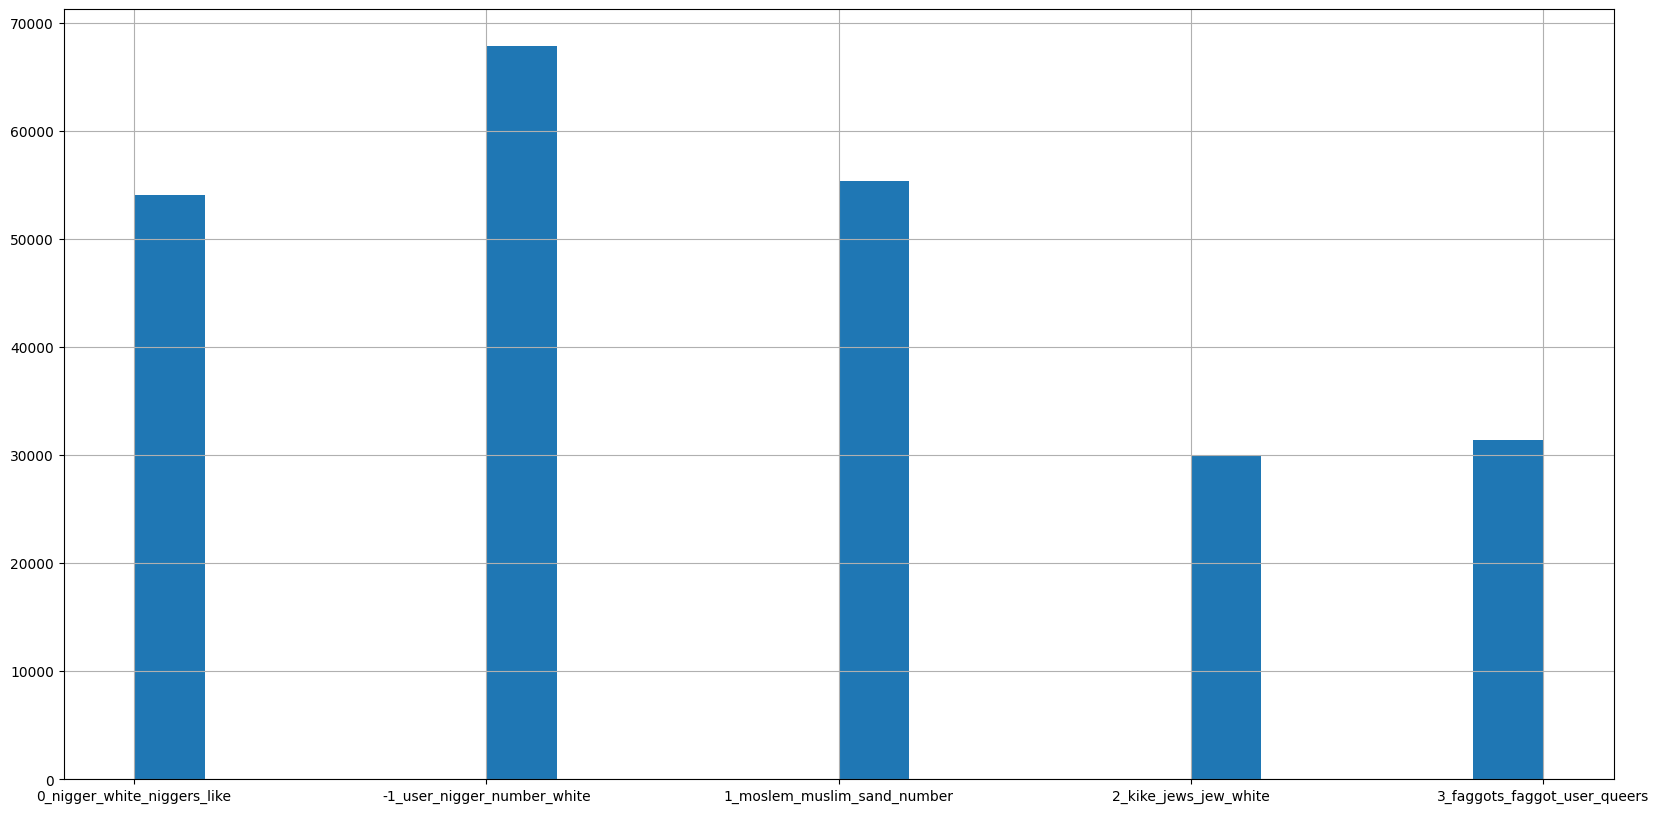

In [5]:
if with_topic:
    topics, probs = topic_model.transform(df.text.values.tolist())
    df['topics'] = [topic_model.topic_names[x] for x in topics]
    df['probs'] = probs
    df['topics'].hist(figsize=(20,10),bins=20)

In [6]:
token_id = []
attention_masks = []
text = df.text.values.tolist()
MAX_LEN = max([len(x.split()) for x in text])
print(MAX_LEN)
# for i, sample in enumerate(text):
encoding_dict = preprocessing(text,tokenizer, MAX_LEN, topic_model)
token_id = encoding_dict['input_ids']
attention_masks = encoding_dict['attention_mask']

# token_id = torch.cat(token_id, dim = 0)
# attention_masks = torch.cat(attention_masks, dim = 0)

157


In [7]:
batch_size = 16

In [8]:
gc.collect()
torch.cuda.empty_cache()


In [9]:
model.to('cuda')
train_set = TensorDataset(token_id, 
                              attention_masks)

data = DataLoader(
                train_set,
                sampler = SequentialSampler(train_set),
                batch_size = batch_size
            )

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 295.84 MiB already allocated; 12.44 MiB free; 314.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
pred_labels = []
for i,batch in enumerate(data):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        eval_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask)
        preds = torch.argmax(eval_output.logits, dim=1)
        pred_labels.extend(preds.cpu().numpy())

In [ ]:
# from guppy import hpy
# h = hpy()
# print(h.heap())
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
labl_dict = {0:'African', 1:'Homosexual', 2:'Islam', 3:'Jewish',4:'other'}

In [ ]:
df['pred'] = [labl_dict[x] for x in pred_labels]
df['pred_labels'] = pred_labels
df['pred'] 

In [ ]:
df.to_csv(fr'../results/{file_name}_{model_name}_{str(with_topic)}.csv')

In [14]:
df

,Unnamed: 0.1,Unnamed: 0,id,text,lang,pred,pred_labels
0,0,0,f2c55d1b981e4e109863cd7b30486a3f,chills ! i loved hearing airforce technical sg...,en,other,4
1,1,2,0c4de495eaef430fb6fd8d5dc9be3453,justice department zeroes in on cuomo 's covid...,en,African,0
2,2,3,2f53cc11f5e541309a59cc89802b9c85,"interesting how ultra-liberal , hysterical , h...",en,other,4
3,3,4,faffec7af75b46c7b7371b7ba90aaae1,petraeus says trump may have restored u . s . ...,en,Islam,2
4,4,5,504c868b51814a07b5a77b1e05f14617,hillary clinton calls bernie sanders a sore lo...,en,other,4
...,...,...,...,...,...,...,...
524984,636475,1095270,04373de74a7a49ffbe9dd85b8d55dce8,my debate opinion ... mission accomplished,en,other,4
524985,636477,1095275,6f3ddd15663142c9af9161fe478d5444,she wants another benghazi and to murder more ...,en,Islam,2
524986,636479,1095282,884918b4c1f14635a8e2f18dda1ba254,"i just shared this to "" chrissy "" wallace 's f...",en,Jewish,3
524987,636480,1095283,d9f44a69a5fa4f77a69fed37a9f8a1f0,what have you got to lose ?,en,other,4


In [17]:
pred_count_dict = {'African':0, 'Homosexual':0, 'Islam':0, 'Jewish':0,'other':0}


In [25]:
pred_count_dict.update(df.groupby('pred').count()['pred_labels'].to_dict())

In [27]:
print(pred_count_dict)

{'African': 28803, 'Homosexual': 10112, 'Islam': 17942, 'Jewish': 25393, 'other': 442739}
